<a href="https://colab.research.google.com/github/AnitaKirkovska/Machine_Learning_Class/blob/master/HW3/VGG19_FineTuning_Visualizaiton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Loading VGG19**

In [4]:
from keras.applications import VGG19

model = VGG19(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.
574717952/574710816 [==============================] - 6s 0us/step


**Loading the Fine Tuned model**

In [1]:
from google.colab import files

uploaded = files.upload()

Saving cats_and_dogs_fine_1.h5 to cats_and_dogs_fine_1 (1).h5


In [5]:
from keras.models import load_model

model.summary()

last_conv_layer = model.get_layer('block5_conv4')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

**Preprocessing Input image**

In [0]:
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input, decode_predictions

In [9]:
!wget https://i.ibb.co/ZcGL8xt/IMG-0558.jpg -O bean_maltese.jpg

!wget https://i.ibb.co/CnqLw7V/mmica.png -O mica_cat.jpg
  
img_path1 = 'bean_maltese.jpg'
img_path2 = 'mica_cat.jpg'

--2019-04-17 13:52:00--  https://i.ibb.co/ZcGL8xt/IMG-0558.jpg
Resolving i.ibb.co (i.ibb.co)... 64.31.6.154
Connecting to i.ibb.co (i.ibb.co)|64.31.6.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98313 (96K) [image/jpeg]
Saving to: ‘bean_maltese.jpg’

bean_maltese.jpg    100%[===================>]  96.01K  --.-KB/s    in 0.1s    

2019-04-17 13:52:01 (730 KB/s) - ‘bean_maltese.jpg’ saved [98313/98313]

--2019-04-17 13:52:01--  https://i.ibb.co/CnqLw7V/mmica.png
Resolving i.ibb.co (i.ibb.co)... 64.31.6.154
Connecting to i.ibb.co (i.ibb.co)|64.31.6.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 441660 (431K) [image/png]
Saving to: ‘mica_cat.jpg’

mica_cat.jpg        100%[===================>] 431.31K  1.57MB/s    in 0.3s    

2019-04-17 13:52:02 (1.57 MB/s) - ‘mica_cat.jpg’ saved [441660/441660]



In [0]:
last_conv_layer = model.get_layer('block5_conv3')

**Preprocessing and visualizing**

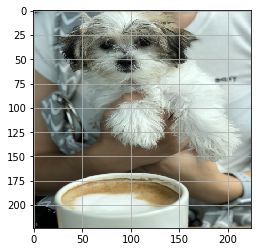

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02098413', 'Lhasa', 0.3889046), ('n02086240', 'Shih-Tzu', 0.32265377)]


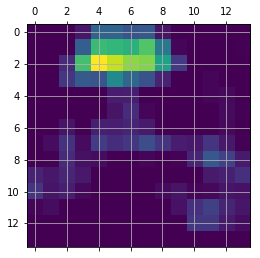

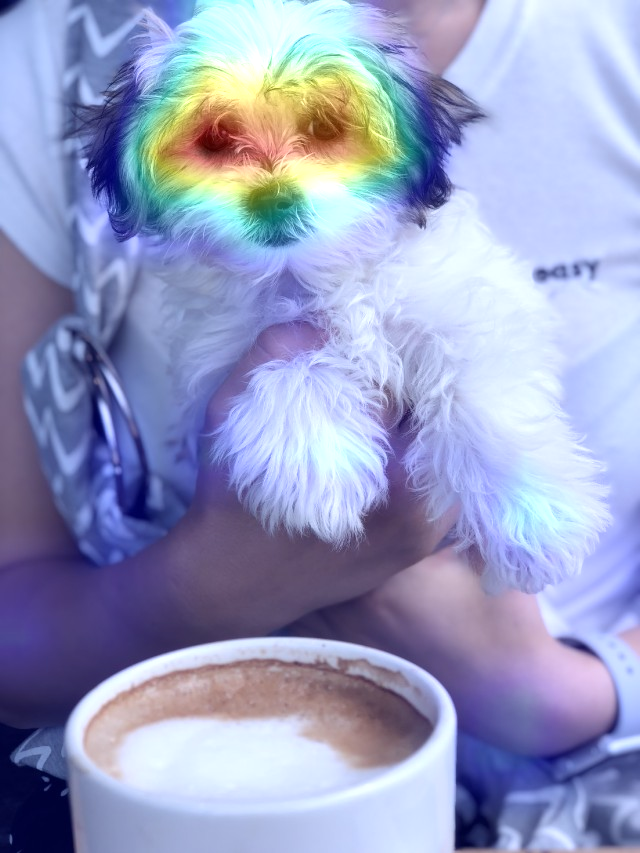

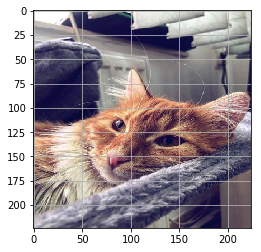

Predicted: [('n02808304', 'bath_towel', 0.35096452), ('n02123159', 'tiger_cat', 0.16749705)]


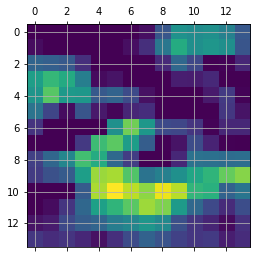

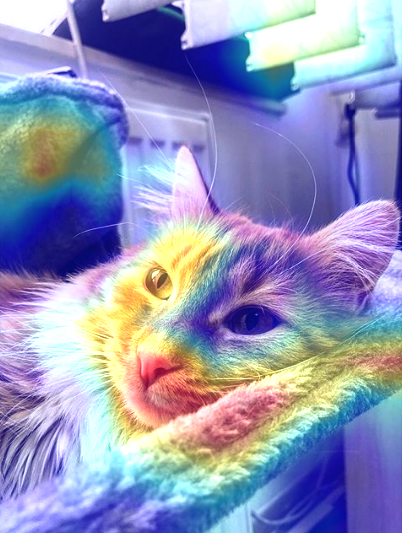

In [11]:
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input, decode_predictions
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import numpy as np
from keras import backend as K

def show_superimposed_image(img_path, heatmap):

  img = cv2.imread(img_path)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = heatmap * 0.4 + img
  cv2_imshow(superimposed_img)
  
def process_image(img_path, idx=0):
  
  img = image.load_img(img_path, target_size=(224, 224))
  
  plt.imshow(img)
  plt.grid(None)
  plt.show()
  
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  
  preds = model.predict(x)
  print('Predicted:', decode_predictions(preds, top=2)[0])
  
  class_index = np.argsort(preds[0])[-(1+idx)]
  class_output = model.output[:, class_index]
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis=-1)
  
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  plt.matshow(heatmap)
  plt.grid(None)
  plt.show()
  
  show_superimposed_image(img_path, heatmap)

process_image(img_path1)
process_image(img_path2)